In [3]:
# 文本处理组件
import torch
# from d2l import torch as d2l
import collections
import re
# from d2l import torch as d2l

class Vocab:
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens==None:
            tokens = []
        if reserved_tokens==None:
            reserved_tokens = []
#         按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx for idx, token in
                           enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs



def count_corpus(tokens):
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [2]:
# train_ch6所需的所有组件
import torch
from torch import nn
from IPython import display
import matplotlib.pyplot as plt
import time
import numpy as np
%matplotlib inline
import torchvision
from torch.utils import data
from torchvision import transforms

def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

# 更新器
def sgd(params, lr, batch):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

# 计时器
class Timer:
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        self.tik = time.time()

    def stop(self):
        self.times.append(time.time()-self.tik)
        return self.times[-1]

    def avg(self):
        return sum(self.times)/len(self.times)

    def sum(self):
        return sum(self.times)

    def cumsum(self):
        return np.array(self.times).cumsum().tolist()


# 精准度的计算
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
          device = next(iter(net.parameters())).device
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
              # BERT微调所需
              X = [x.to(device) for x in X]
            else:
              X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 参数储存器
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# 画图部分
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        # d2l.use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

# mini-batch取数据
def get_dataloader_workers():
  #使用四个线程
    return 4

def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()), data.DataLoader(mnist_test, batch_size, shuffle=False,
                num_workers=get_dataloader_workers()))

def try_gpu(i=0):
  """如果存在，则返回gpu(i)，否则返回cpu()"""
  if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
  return torch.device('cpu')


  # 训练
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# 14.3 用于预训练词嵌入的数据集

def read_ptb():
  with open('/content/drive/MyDrive/Colab Notebooks/ptb/ptb.train.txt') as f:
    raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
print(f'# sentence size: {len(sentences)}')

vocab = Vocab(sentences, min_freq=10)
print(f'# vocab size: {len(vocab)}')

import math
import random

# 14.3.2 下采样
def subsample(sentences, vocab):
  # 排除未知词元<unk>
  sentences = [[token for token in line if vocab[token] != vocab.unk]
               for line in sentences]
  counter = count_corpus(sentences)
  num_tokens = sum(counter.values())
  def keep(token):
    return (random.uniform(0, 1) <
            math.sqrt(1e-4 / counter[token] * num_tokens))

  return ([[token for token in line if keep(token)] for line in sentences],
          counter)

subsampled, counter = subsample(sentences, vocab)

def compare_counts(token):
  return (f'"{token}"的数量:'
  f'之前={sum([l.count(token) for l in sentences])}, '
  f'之后={sum([l.count(token) for l in subsampled])}')

def get_centers_and_contexts(corpus, max_window_size):
    """返回跳元模型中的中心词和上下文词"""
    centers, contexts = [], []
    for line in corpus:
        # 要形成“中心词-上下文词”对，每个句子至少需要有2个词
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # 上下文窗口中间i
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # 从上下文词中排除中心词
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

# 14.3.4 负采样
class RandomGenerator:
  def __init__(self, sampling_weights):
    self.population = list(range(1, len(sampling_weights) + 1))
    self.sampling_weights = sampling_weights
    self.candidates = []
    self.i = 0

  def draw(self):
    if self.i == len(self.candidates):
      self.candidates = random.choices(
          self.population, self.sampling_weights, k=10000
      )
      self.i = 0
    self.i += 1
    return self.candidates[self.i - 1]

def get_negatives(all_contexts, vocab, counter, K):
  sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                      for i in range(1, len(vocab))]
  all_negatives, generator = [], RandomGenerator(sampling_weights)
  for contexts in all_contexts:
    negatives = []
    while len(negatives) < len(contexts) * K:
      neg = generator.draw()
      if neg not in contexts:
        negatives.append(neg)
    all_negatives.append(negatives)
  return all_negatives

# all_negatives = get_negatives(all_contexts, vocab, counter, 5)

def batchify(data):
    """返回带有负采样的跳元模型的小批量样本"""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += \
            [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

# 集合所有组件
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """下载PTB数据集，然后将其加载到内存中"""
    num_workers = 2
    sentences = read_ptb()
    vocab = Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)
    # print(len(dataset.contexts))

    data_iter = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True,
        collate_fn=batchify, num_workers=num_workers)
    return data_iter, vocab

# sentence size: 42069
# vocab size: 6719


In [5]:
# 14.4 预训练word2vec
import math
import torch
from torch import nn
# from d2l import torch as d2l

batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = load_data_ptb(batch_size, max_window_size,
                                     num_noise_words)

def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

class SigmoidBCELoss(nn.Module):
    # 带掩码的二元交叉熵损失
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))

def train(net, data_iter, lr, num_epochs, device=try_gpu()):
  def init_weights(m):
    if type(m) == nn.Embedding:
      nn.init.xavier_uniform_(m.weight)
  net.apply(init_weights)
  net = net.to(device)
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # 规范化的损失之和，规范化的损失数
  metric = Accumulator(2)
  for epoch in range(num_epochs):
    timer, num_batches = Timer(), len(data_iter)
    for i, batch in enumerate(data_iter):
      optimizer.zero_grad()
      center, context_negative, mask, label = [
          data.to(device) for data in batch
      ]
      pred = skip_gram(center, context_negative, net[0], net[1])
      l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
      l.sum().backward()
      optimizer.step()
      metric.add(l.sum(), l.numel())
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
  print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')


def get_similar_tokens(query_token, k, embed):
  W = embed.weight.data
  x = W[vocab[query_token]]
  cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                    torch.sum(x * x) + 1e-9)
  topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
  for i in topk[1:]:  # 删除输入词
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

loss 0.410, 93493.4 tokens/sec on cpu


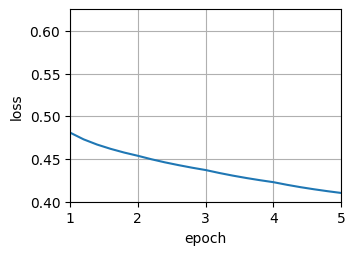

In [6]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

In [7]:
get_similar_tokens('chip', 3, net[0])

cosine sim=0.696: microprocessor
cosine sim=0.684: intel
cosine sim=0.630: mips


In [6]:
# 14.6.2 BPE

import collections

symbols = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
           '_', '[UNK]']

raw_token_freqs = {'fast_': 4, 'faster_': 3, 'tall_': 5, 'taller_': 4}
token_freqs = {}
for token, freq in raw_token_freqs.items():
  token_freqs[' '.join(list(token))] = raw_token_freqs[token]
print(token_freqs)

def get_max_freq_pair(token_freqs):
  pairs = collections.defaultdict(int)
  for token, freqs in token_freqs.items():
    symbols = token.split()
    for i in range(len(symbols) - 1):
      pairs[symbols[i], symbols[i+1]] += freqs
  return max(pairs, key=pairs.get)

def merge_symbols(max_freq_pair, token_freqs, symbols):
  symbols.append(''.join(max_freq_pair))
  new_token_freqs = dict()
  for token, freq in token_freqs.items():
    new_token = token.replace(' '.join(max_freq_pair),
                              ''.join(max_freq_pair))
    new_token_freqs[new_token] = freq
  return new_token_freqs

num_merges = 10
for i in range(num_merges):
    max_freq_pair = get_max_freq_pair(token_freqs)
    token_freqs = merge_symbols(max_freq_pair, token_freqs, symbols)
    print(f'合并# {i+1}:',max_freq_pair)

print(symbols)

def segment_BPE(tokens, symbols):
    outputs = []
    for token in tokens:
        start, end = 0, len(token)
        cur_output = []
        # 具有符号中可能最长子字的词元段
        while start < len(token) and start < end:
            if token[start: end] in symbols:
                cur_output.append(token[start: end])
                start = end
                end = len(token)
            else:
                end -= 1
        if start < len(token):
            cur_output.append('[UNK]')
        outputs.append(' '.join(cur_output))
    return outputs

tokens = ['tallest_', 'fatter_']
print(segment_BPE(tokens, symbols))

{'f a s t _': 4, 'f a s t e r _': 3, 't a l l _': 5, 't a l l e r _': 4}
合并# 1: ('t', 'a')
合并# 2: ('ta', 'l')
合并# 3: ('tal', 'l')
合并# 4: ('f', 'a')
合并# 5: ('fa', 's')
合并# 6: ('fas', 't')
合并# 7: ('e', 'r')
合并# 8: ('er', '_')
合并# 9: ('tall', '_')
合并# 10: ('fast', '_')
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[UNK]', 'ta', 'tal', 'tall', 'fa', 'fas', 'fast', 'er', 'er_', 'tall_', 'fast_']
['tall e s t _', 'fa t t er_']


In [16]:
# 14.7 词的相似性和类比性
import os
import torch
from torch import nn

class TokenEmbedding:
    """GloVe嵌入"""
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(
            embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        # data_dir = d2l.download_extract(embedding_name)
        # GloVe网站：https://nlp.stanford.edu/projects/glove/
        # fastText网站：https://fasttext.cc/
        # if embedding_name[:5] == 'glove':
        data_dir = '/content/drive/MyDrive/Colab Notebooks'
        # else:
          # data_dir = 'https://fasttext.cc/'
        with open(os.path.join(data_dir, embedding_name, 'vec.txt'), 'r') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # 跳过标题信息，例如fastText中的首行
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

def knn(W, x, k):
  cos = torch.mv(W, x.reshape((-1,))) / (
      torch.sqrt(torch.sum(W * W, axis=1) + 1e-9) *
      torch.sqrt((x * x).sum())
  )
  _, topk = torch.topk(cos, k=k)
  return topk, [cos[i] for i in topk]

def get_similar_tokens(query_token, k, embed):
    topk, cos = knn(embed.idx_to_vec, embed[[query_token]], k + 1)
    for i, c in zip(topk[1:], cos[1:]):  # 排除输入词
        print(f'{embed.idx_to_token[int(i)]}：cosine相似度={float(c):.3f}')

def get_analogy(token_a, token_b, token_c, embed):
    vecs = embed[[token_a, token_b, token_c]]
    x = vecs[1] - vecs[0] + vecs[2]
    topk, cos = knn(embed.idx_to_vec, x, 1)
    return embed.idx_to_token[int(topk[0])]  # 删除未知词

In [8]:
glove_6b50d = TokenEmbedding('glove.6B.50d')

In [15]:
get_similar_tokens('chip', 3, glove_6b50d)
get_similar_tokens('baby', 3, glove_6b50d)
get_similar_tokens('beautiful', 3, glove_6b50d)


chips：cosine相似度=0.856
intel：cosine相似度=0.749
electronics：cosine相似度=0.749
babies：cosine相似度=0.839
boy：cosine相似度=0.800
girl：cosine相似度=0.792
lovely：cosine相似度=0.921
gorgeous：cosine相似度=0.893
wonderful：cosine相似度=0.830


In [18]:
print(
get_analogy('man', 'woman', 'son', glove_6b50d),
get_analogy('beijing', 'china', 'tokyo', glove_6b50d),
get_analogy('bad', 'worst', 'big', glove_6b50d),
get_analogy('do', 'did', 'go', glove_6b50d))

daughter japan biggest went
